<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/Inception_Try3_Dealimbalance_2211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Mounted at /content/drive
Epoch [1/20], Loss: 3.973797
Validation Accuracy: 16.23%
New best model saved with accuracy: 16.23% at /content/drive/My Drive/FYP/CustomModel/HQ2_20241229_140404/best_model_20241229_140404.pth
Epoch [2/20], Loss: 1.733034
Validation Accuracy: 79.87%
New best model saved with accuracy: 79.87% at /content/drive/My Drive/FYP/CustomModel/HQ2_20241229_140404/best_model_20241229_140404.pth
Epoch [3/20], Loss: 0.784395
Validation Accuracy: 69.48%
Epoch [4/20], Loss: 0.610451
Validation Accuracy: 73.38%
Epoch [5/20], Loss: 0.519393
Validation Accuracy: 74.68%
Epoch [6/20], Loss: 0.565927
Validation Accuracy: 75.32%
Epoch [7/20], Loss: 0.527652
Validation Accuracy: 77.27%
Epoch [8/20], Loss: 0.552715
Validation Accuracy: 81.82%
New best model saved with accuracy: 81.82% at /content/drive/My Drive/FYP/CustomModel/HQ2_20241229_140404/best_model_20241229_140404.pth
Epoch [9/20], Loss: 0.492302
Validation Accuracy: 67.53%
Epoch [10/20], Loss: 0.520004
Va

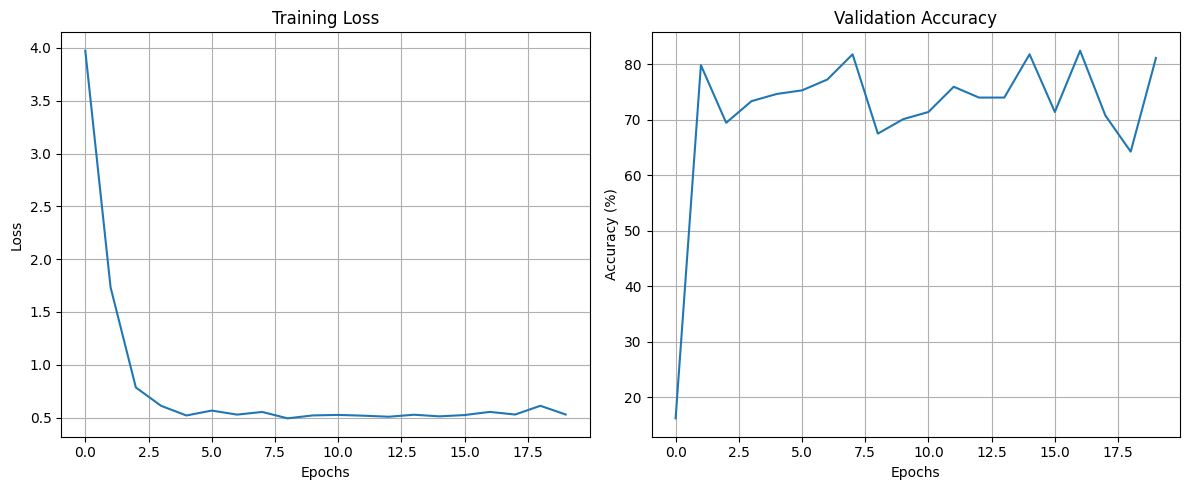

Final model saved at /content/drive/My Drive/FYP/CustomModel/HQ2_20241229_140404/final_model_20241229_140404.pth
Test Accuracy: 80.00%


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
date_str = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_folder = f'/content/drive/My Drive/FYP/CustomModel/HQ2_{date_str}/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQ2/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQ2/test'

train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Calculate class weights for handling imbalance
targets = [label for _, label in train_dataset]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
weights = [class_weights[label] for _, label in train_dataset]
weights = torch.tensor(weights, dtype=torch.float)

# Create a weighted sampler
train_sampler = torch.utils.data.WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a lightweight SE block for channel-wise attention
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        batch, channels, _, _ = x.size()
        se = torch.mean(x, (2, 3))  # Global Average Pooling
        se = torch.relu(self.fc1(se))
        se = torch.sigmoid(self.fc2(se))
        se = se.view(batch, channels, 1, 1)
        return x * se

# Define an improved CNN architecture with SE Block
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            SEBlock(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            SEBlock(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SEBlock(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)  # Binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize the model, loss, optimizer, and scheduler
model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training loop with checkpointing
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    best_acc = 0.0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print training loss
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.6f}")

        # Validate the model
        val_acc = validate(model, val_loader)
        val_accuracies.append(val_acc)
        scheduler.step()

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_path = os.path.join(checkpoint_folder, f"best_model_{date_str}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {best_acc:.2f}% at {best_model_path}")

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    # Save the final model
    final_model_path = os.path.join(checkpoint_folder, f"final_model_{date_str}.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")

# Validation loop returning accuracy
def validate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return accuracy

# Test function to evaluate on the test set
def test(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Step 1: Train the model with learning rate scheduling
train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

# Step 2: Evaluate the model on the test set
test(model, test_loader)


In [ ]:
import os

# Path to the dataset
gwg_path = '/content/drive/My Drive/FYP/Dataset/HQ2/train/Glaucous_Winged_Gull'
sbg_path = '/content/drive/My Drive/FYP/Dataset/HQ2/train/Slaty_Backed_Gull'

# Check the number of valid image files in each folder
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

def count_valid_images(folder_path):
    if os.path.exists(folder_path):
        files = os.listdir(folder_path)
        valid_files = [f for f in files if os.path.splitext(f)[1].lower() in valid_extensions]
        return len(valid_files), valid_files
    return 0, []

gwg_count, gwg_files = count_valid_images(gwg_path)
sbg_count, sbg_files = count_valid_images(sbg_path)

print(f"Number of valid images in Glaucous_Winged_Gull: {gwg_count}")
print(f"Valid files: {gwg_files}")
print(f"Number of valid images in Slaty_Backed_Gull: {sbg_count}")
print(f"Valid files: {sbg_files}")



Number of valid images in Glaucous_Winged_Gull: 199
Valid files: ['istockphoto-1278465050-612x612.jpg', '2d5006r.jpg', 'e551gy.jpg', 'images (25).jpg', 'gwguflight-seward-20130613-1600.jpg', '39446161-480px.jpg', '2b1158y.jpg', '2b116d8.jpg', 'images (21).jpg', '900 - 2024-10-22T213925.130.jpg', '900 (80).jpg', '71320901-480px.jpg', '900 - 2024-10-22T213923.030.jpg', '900 - 2024-10-22T213923.051.jpg', '900 (76).jpg', '900 (44).jpg', '1200 - 2024-10-22T213919.160.jpg', '900 - 2024-10-22T213925.169.jpg', '900 - 2024-10-22T213923.089.jpg', '900 - 2024-10-22T213922.996.jpg', '900 - 2024-10-22T213925.074.jpg', '900 (94).jpg', '900 (83).jpg', '900 - 2024-10-22T213922.395.jpg', '900 - 2024-10-22T213919.842.jpg', '900 - 2024-10-22T213922.437.jpg', '900 - 2024-10-22T213925.153.jpg', '900 - 2024-10-22T213922.053.jpg', '900 - 2024-10-22T213922.377.jpg', '900 - 2024-10-22T213922.285.jpg', '900 - 2024-10-22T213922.220.jpg', '900 - 2024-10-22T213922.036.jpg', '900 - 2024-10-22T213922.878.jpg', '900 